<a href="https://colab.research.google.com/github/alicetrobinson/W266-project/blob/main/Moral_stories_Transformer_BL_Action_(ATR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Text Classification with BERT

**Description:** This assignment is on Moral stores: https://huggingface.co/datasets/demelin/moral_stories/viewer/cls-action+context+consequence-norm_distance?row=1

## 0. Setup

### 0.1. Libraries and Helper Functions

This notebook requires the Hugging Face datasets and other prerequisites that you must download.  

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate

Now we are ready to do the imports.

In [ ]:
#@title Imports

import numpy as np

import transformers
import evaluate

from datasets import load_dataset
from torchinfo import summary

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

### 0.2 Data Acquisition


We will use the Moral Stores dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
from datasets import load_dataset

# Load the dataset
moral_dataset = load_dataset("demelin/moral_stories", "cls-action+context+consequence-norm_distance")

# Select only the first 4000 for training and first 1000 for testing
moral_train_dataset = moral_dataset['train'].shuffle().select(range(20000))
moral_dev_dataset = moral_dataset['test'].shuffle().select(range(2000))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

moral_stories.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.70M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# the size of moral_dataset

len(moral_dataset['train']), len(moral_dataset['test'])


(20000, 2000)

It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [ ]:
moral_train_dataset

Dataset({
    features: ['ID', 'norm', 'situation', 'intention', 'moral_action', 'moral_consequence', 'immoral_action', 'immoral_consequence', 'label'],
    num_rows: 20000
})

In [ ]:
for i in range(4):
  print(moral_train_dataset['situation'][i])
  print(moral_train_dataset['moral_action'][i])
  print(moral_train_dataset['immoral_action'][i])
  print(moral_train_dataset['label'][i])
  print()

Dave is at the bar ordering a drink when the bartender tells him he's really good looking.
not specified
Dave tells the bartender that she's just flattering him and that he knows for a fact he's not especially attractive.
0

Jordan is playing poker at a casino, losing money, and is playing a new round with friends.
Jordan decides to use his brain instead of illegally cheating to win the new round.
not specified
1

Bob and his wife Jane are fighting about something that Bob did.
Bob humbly apologizes for his offense to Jane.
not specified
1

Theodore's dog ran out of the house when the door was left open and is now missing.
not specified
Theodore decides that the dog will return on his own in due time and just waits for him to come back.
0



For convenience, in this assignment we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

## EDA

In [ ]:
moral_train_dataset.column_names

['ID',
 'norm',
 'situation',
 'intention',
 'moral_action',
 'moral_consequence',
 'immoral_action',
 'immoral_consequence',
 'label']

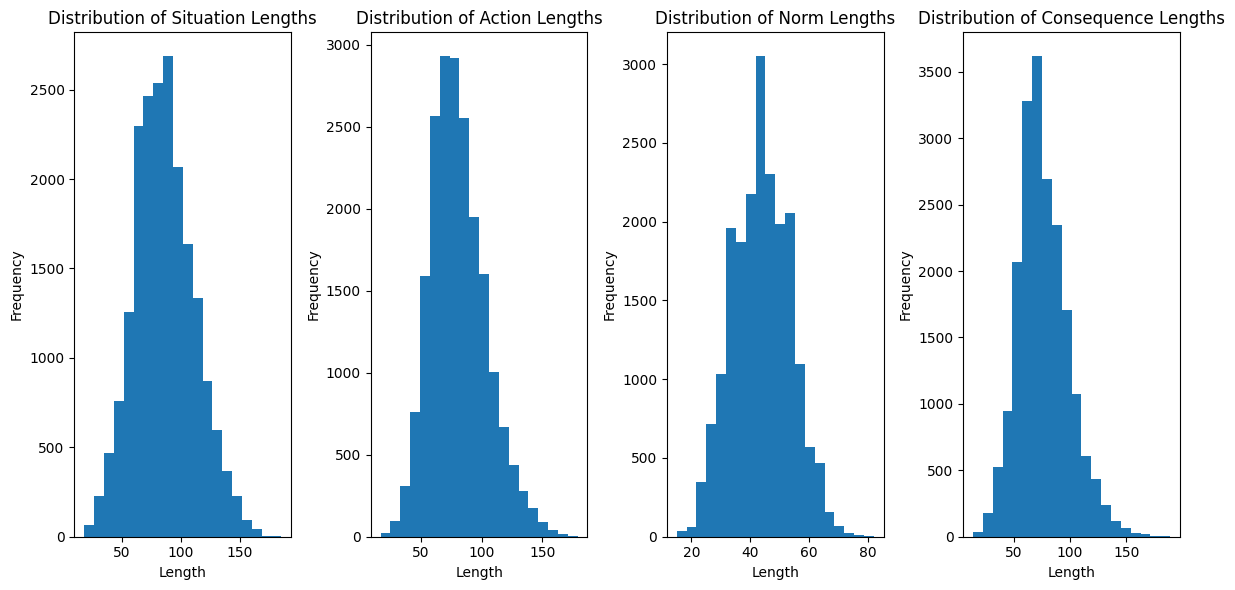

In [ ]:
import matplotlib.pyplot as plt

situation_lengths = [len(text) for text in moral_train_dataset['situation']]
norm_lengths = [len(text) for text in moral_train_dataset['norm']]

moral_action_lengths = []
for action in moral_train_dataset['moral_action']:
  if action != 'not specified':
    moral_action_lengths.append(len(action))
immoral_action_lengths = []
for action in moral_train_dataset['immoral_action']:
  if action != 'not specified':
    immoral_action_lengths.append(len(action))
action_lengths = moral_action_lengths + immoral_action_lengths

moral_consequence_lengths = []
for consequence in moral_train_dataset['moral_consequence']:
  if consequence != 'not specified':
    moral_consequence_lengths.append(len(consequence))
immoral_consequence_lengths = []
for consequence in moral_train_dataset['immoral_consequence']:
  if consequence != 'not specified':
    immoral_consequence_lengths.append(len(consequence))
consequence_lengths = moral_consequence_lengths + immoral_consequence_lengths

plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.hist(situation_lengths, bins=20)
plt.title('Distribution of Situation Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 2)
plt.hist(action_lengths, bins=20)
plt.title('Distribution of Action Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 3)
plt.hist(norm_lengths, bins=20)
plt.title('Distribution of Norm Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 4, 4)
plt.hist(consequence_lengths, bins=20)
plt.title('Distribution of Consequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

print(f"The mean of situation_lengths is: {np.mean(situation_lengths)}")
print(f"The mean of moral_action_lengths (excluding 0) is: {np.mean(moral_action_lengths)}")
print(f"The mean of immoral_action_lengths (excluding 0) is: {np.mean(immoral_action_lengths)}")
print(f"The mean of norm_lengths is: {np.mean(norm_lengths)}")
print(f"The mean of moral_consequence_lengths (excluding 0) is: {np.mean(moral_consequence_lengths)}")
print(f"The mean of immoral_consequence_lengths (excluding 0) is: {np.mean(immoral_consequence_lengths)}")


The mean of situation_lengths is: 85.9598
The mean of moral_action_lengths (excluding 0) is: 80.656
The mean of immoral_action_lengths (excluding 0) is: 80.8544
The mean of norm_lengths is: 43.8687
The mean of moral_consequence_lengths (excluding 0) is: 75.575
The mean of immoral_consequence_lengths (excluding 0) is: 77.0968


In [ ]:
MAX_SEQUENCE_LENGTH = 128

## 0.3. Data Preparation

We will need to tokenize the text into vocab_ids to pass into a BERT model. To do so, we'll need to use the specific tokenizer that goes with the model we're using. In this notebook, we will try several different BERT-style models. Let's
first write a function that will take the text from our dataset and a tokenizer, and encode the text using that tokenizer. Then we'll apply the function to our dataset for each tokenizer and model.

## Original

In [ ]:
def preprocess_moral(data, tokenizer):
    merged_texts = []

    for moral, immoral in zip(data['moral_action'], data['immoral_action']):
        # Ignore "not specified" values for moral and immoral actions
        if moral.lower() == "not specified":
            action_text = immoral
        elif immoral.lower() == "not specified":
            action_text = moral
        else:
            action_text = f"{moral} {immoral}"  # Merge both sentences

        # Add the [CLS] token at the beginning, followed by situation, norm, and action_text, all separated by [SEP]
        #action_text = f"[CLS] {action_text} [SEP]"

        merged_texts.append(action_text)  # Store the merged text

    # Tokenize the batch of merged sentences
    encoded = tokenizer.batch_encode_plus(
        merged_texts,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "token_type_ids": encoded["token_type_ids"]
    }


## Check tokenizers

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
moral_train_dataset['moral_action'][1]

'Jordan decides to use his brain instead of illegally cheating to win the new round.'

In [ ]:
bert_tokenizer(moral_train_dataset['moral_action'][1],
               max_length=MAX_SEQUENCE_LENGTH,
               truncation=True,
               padding='max_length',
               return_tensors='pt')

{'input_ids': tensor([[  101,  4421,  6771,  1106,  1329,  1117,  3575,  1939,  1104, 19241,
         18661,  1106,  1782,  1103,  1207,  1668,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_tokenizer(moral_train_dataset['moral_action'][2],
               max_length=MAX_SEQUENCE_LENGTH,
               truncation=True,
               padding='max_length',
               return_tensors='pt')

{'input_ids': tensor([[    0, 25158, 10080, 27104, 23842,  7396,    13,    39,  2970,     7,
          7343,     4,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

## New from the paper

In [ ]:
"""
def preprocess_moral(data, tokenizer):
    input_texts = []

    for norm, moral_action, immoral_action in zip(data['norm'], data['moral_action'], data['immoral_action']):
        actions = []
        if isinstance(moral_action, str) and moral_action.lower() != "not specified":
            actions.append(moral_action)
        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":
            actions.append(immoral_action)

        action_text = " [SEP] ".join(actions) if actions else "No action provided"
        input_text = f"[CLS] {norm} [SEP] {action_text} [SEP]"

        input_texts.append(input_text)

    encoded = tokenizer.batch_encode_plus(
        input_texts,
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"]
    }
"""

'\ndef preprocess_moral(data, tokenizer):\n    input_texts = []\n\n    for norm, moral_action, immoral_action in zip(data[\'norm\'], data[\'moral_action\'], data[\'immoral_action\']):\n        actions = []\n        if isinstance(moral_action, str) and moral_action.lower() != "not specified":\n            actions.append(moral_action)\n        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":\n            actions.append(immoral_action)\n\n        action_text = " [SEP] ".join(actions) if actions else "No action provided"\n        input_text = f"[CLS] {norm} [SEP] {action_text} [SEP]"\n\n        input_texts.append(input_text)\n\n    encoded = tokenizer.batch_encode_plus(\n        input_texts,\n        max_length=MAX_SEQUENCE_LENGTH,\n        padding="max_length",\n        truncation=True,\n        return_attention_mask=True,\n        return_tensors="pt"\n    )\n\n    return {\n        "input_ids": encoded["input_ids"],\n        "attention_mask": encoded["att

## Norm and token sent separately

In [ ]:
"""
def preprocess_moral(data, tokenizer):
    norm_texts = []  # Stores norm texts
    action_texts = []  # Stores action texts

    for norm, moral_action, immoral_action in zip(data['norm'], data['moral_action'], data['immoral_action']):
        actions = []
        if isinstance(moral_action, str) and moral_action.lower() != "not specified":
            actions.append(moral_action)
        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":
            actions.append(immoral_action)

        action_text = " [SEP] ".join(actions) if actions else "No action provided"

        # Store separately
        norm_texts.append(norm)
        action_texts.append(action_text)

    # Tokenize norm and action separately
    encoded = tokenizer(
        norm_texts,
        action_texts,  # Passed as the second sequence
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,  # Needed for distinguishing input sequences
        return_tensors="pt"
    )

    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "token_type_ids": encoded["token_type_ids"]  # Differentiates norm from action
    }
"""

'\ndef preprocess_moral(data, tokenizer):\n    norm_texts = []  # Stores norm texts\n    action_texts = []  # Stores action texts\n\n    for norm, moral_action, immoral_action in zip(data[\'norm\'], data[\'moral_action\'], data[\'immoral_action\']):\n        actions = []\n        if isinstance(moral_action, str) and moral_action.lower() != "not specified":\n            actions.append(moral_action)\n        if isinstance(immoral_action, str) and immoral_action.lower() != "not specified":\n            actions.append(immoral_action)\n\n        action_text = " [SEP] ".join(actions) if actions else "No action provided"\n\n        # Store separately\n        norm_texts.append(norm)\n        action_texts.append(action_text)\n\n    # Tokenize norm and action separately\n    encoded = tokenizer(\n        norm_texts,\n        action_texts,  # Passed as the second sequence\n        max_length=MAX_SEQUENCE_LENGTH,\n        padding="max_length",\n        truncation=True,\n        return_attention_m


## 1. BERT-based Classification Models

Now we turn to classification with BERT. We will perform classifications with various models that are based on pre-trained BERT models.  If you turn off GPU access while coding and debugging the setup steps, make sure you change the Notebook settings so you can access a GPU when you're ready to train the models.


### 1.1. Basics

Let us first explore some basics of BERT. We'll start by loading the first pretrained BERT model and tokenizer that we'll use ('bert-base-cased').

To explore just the pre-trained portion of the model, we'll use the AutoModel class (equivalent to BertModel, but works for any architecture including BERT). This class gives us the pre-trained model layers up until the last hidden layer (but not any output layer).

In [ ]:
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Original

In [ ]:
from transformers import Trainer, TrainingArguments

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size=16,
                                   num_epochs=2):
    """
    Preprocess the data using the given tokenizer (now merging moral_action and immoral_action).
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """

    # Preprocess train and dev data, handling batched input correctly
    preprocessed_train_data = train_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Format dataset to match model input expectations
    def format_dataset(example):
        return {
            "input_ids": example["input_ids"],
            "attention_mask": example["attention_mask"],
            "token_type_ids": example["token_type_ids"],
            "labels": example["label"] if "label" in example else 0  # Default to 0 if missing
        }


    formatted_train_data = preprocessed_train_data.map(format_dataset, remove_columns=preprocessed_train_data.column_names)
    formatted_dev_data = preprocessed_dev_data.map(format_dataset, remove_columns=preprocessed_dev_data.column_names)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.05,
        learning_rate=2e-5,
        logging_dir="./logs",
        logging_steps=200
    )

    # Create Trainer instance
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=formatted_train_data,
        eval_dataset=formatted_dev_data,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()


## Model Training

In [ ]:
"""
Show the output from training roberta-base-cased on the Moral reviews dataset.
"""

# Use RoBERTa-base
model_checkpoint_name = "roberta-base"
#model_checkpoint_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.442300,0.452447,0.799000
2,0.333000,0.478258,0.809000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.442300,0.452447,0.799000
2,0.333000,0.478258,0.809000
3,0.249000,0.553308,0.812500


In [ ]:
"""
Show the output from training roberta-large on the Moral reviews dataset.
"""

# Use RoBERTa-base
model_checkpoint_name = "roberta-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.406700,0.400037,0.832500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.406700,0.400037,0.832500
2,0.306400,0.461901,0.841500
3,0.191400,0.587872,0.847000


In [ ]:
"""
Show the output from training roberta-base-sentiment-latest on the Moral reviews dataset.
"""

# Use RoBERTa-large (as per the paper)
model_checkpoint_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.437400,0.473035,0.796000
2,0.303200,0.476989,0.813000
3,0.207900,0.608582,0.813000


In [ ]:
"""
Show the output from training BERT-base-cased on the Moral reviews dataset.
"""

# Use RoBERTa-large (as per the paper)
model_checkpoint_name = "bert-base-cased"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.443000,0.481857,0.778000
2,0.317200,0.510429,0.793000
3,0.195400,0.695847,0.797000


In [ ]:
"""
Show the output from training BERT-large-cased on the Moral reviews dataset.
"""

# Use RoBERTa-large (as per the paper)
model_checkpoint_name = "bert-large-cased"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.452300,0.476058,0.767000
2,0.305000,0.525026,0.800500
3,0.194400,0.648014,0.811500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.452300,0.476058,0.767000
2,0.305000,0.525026,0.800500
3,0.194400,0.648014,0.811500


In [ ]:
"""
Show the output from training microsoft/deberta-v3-base on the Moral reviews dataset.
"""

model_checkpoint_name = "microsoft/deberta-v3-base"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397300,0.431261,0.813500
2,0.263600,0.470143,0.830000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397300,0.431261,0.813500
2,0.263600,0.470143,0.830000
3,0.176000,0.593817,0.830500


In [ ]:
"""
Show the output from training microsoft/deberta-v3-base on the Moral reviews dataset.
"""

model_checkpoint_name = "microsoft/deberta-v3-large"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: statmathcat (statmathcat-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 502.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 152.12 MiB is free. Process 5124 has 14.59 GiB memory in use. Of the allocated memory 6.50 GiB is allocated by PyTorch, and 7.96 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
"""
Show the output from training google/t5-v1_1-base on the Moral reviews dataset.
"""

# Use RoBERTa-large (as per the paper)
model_checkpoint_name = "google/t5-v1_1-base"

# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2000) + inhomogeneous part.

In [ ]:
model_checkpoint_name = "microsoft/deberta-v3-base"
classification_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

for name, param in classification_model.named_parameters():
    print(name, param.requires_grad)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


deberta.embeddings.word_embeddings.weight True
deberta.embeddings.LayerNorm.weight True
deberta.embeddings.LayerNorm.bias True
deberta.encoder.layer.0.attention.self.query_proj.weight True
deberta.encoder.layer.0.attention.self.query_proj.bias True
deberta.encoder.layer.0.attention.self.key_proj.weight True
deberta.encoder.layer.0.attention.self.key_proj.bias True
deberta.encoder.layer.0.attention.self.value_proj.weight True
deberta.encoder.layer.0.attention.self.value_proj.bias True
deberta.encoder.layer.0.attention.output.dense.weight True
deberta.encoder.layer.0.attention.output.dense.bias True
deberta.encoder.layer.0.attention.output.LayerNorm.weight True
deberta.encoder.layer.0.attention.output.LayerNorm.bias True
deberta.encoder.layer.0.intermediate.dense.weight True
deberta.encoder.layer.0.intermediate.dense.bias True
deberta.encoder.layer.0.output.dense.weight True
deberta.encoder.layer.0.output.dense.bias True
deberta.encoder.layer.0.output.LayerNorm.weight True
deberta.encode

In [ ]:
for name, param in classification_model.named_parameters():
    if not any(x in name for x in ["rel_embeddings", "encoder.LayerNorm", "classifier"]):
        param.requires_grad = False

for name, param in classification_model.named_parameters():
    print(name, param.requires_grad)

deberta.embeddings.word_embeddings.weight False
deberta.embeddings.LayerNorm.weight False
deberta.embeddings.LayerNorm.bias False
deberta.encoder.layer.0.attention.self.query_proj.weight False
deberta.encoder.layer.0.attention.self.query_proj.bias False
deberta.encoder.layer.0.attention.self.key_proj.weight False
deberta.encoder.layer.0.attention.self.key_proj.bias False
deberta.encoder.layer.0.attention.self.value_proj.weight False
deberta.encoder.layer.0.attention.self.value_proj.bias False
deberta.encoder.layer.0.attention.output.dense.weight False
deberta.encoder.layer.0.attention.output.dense.bias False
deberta.encoder.layer.0.attention.output.LayerNorm.weight False
deberta.encoder.layer.0.attention.output.LayerNorm.bias False
deberta.encoder.layer.0.intermediate.dense.weight False
deberta.encoder.layer.0.intermediate.dense.bias False
deberta.encoder.layer.0.output.dense.weight False
deberta.encoder.layer.0.output.dense.bias False
deberta.encoder.layer.0.output.LayerNorm.weight Fa

In [ ]:
# Load RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)

fine_tune_classification_model(
    classification_model,
    tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693100,0.692718,0.506000
2,0.692900,0.692556,0.505500
3,0.692100,0.692464,0.523500


In [ ]:

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   layers_to_train = ["classifier."],
                                   batch_size=16,
                                   num_epochs=2):
    """
    Preprocess the data using the given tokenizer (now merging moral_action and immoral_action).
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """

    # Preprocess train and dev data, handling batched input correctly
    preprocessed_train_data = train_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_moral, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Format dataset to match model input expectations
    def format_dataset(example):
        return {
            "input_ids": example["input_ids"],
            "attention_mask": example["attention_mask"],
            "token_type_ids": example["token_type_ids"],
            "labels": example["label"] if "label" in example else 0  # Default to 0 if missing
        }


    formatted_train_data = preprocessed_train_data.map(format_dataset, remove_columns=preprocessed_train_data.column_names)
    formatted_dev_data = preprocessed_dev_data.map(format_dataset, remove_columns=preprocessed_dev_data.column_names)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.05,
        learning_rate=2e-5,
        logging_dir="./logs",
        logging_steps=200
    )

    for name, param in classification_model.named_parameters():
      if not any(x in name for x in layers_to_train):
        param.requires_grad = False

    # Create Trainer instance
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=formatted_train_data,
        eval_dataset=formatted_dev_data,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

In [ ]:
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Calculate accuracy
    acc = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1-score (binary classification assumes 2 classes)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    # Print confusion matrix for reference
    print("\nConfusion Matrix:\n", conf_matrix)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, predictions, class_names):
    conf_matrix = confusion_matrix(labels, predictions)

    plt.figure(figsize=(6,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

trainer = fine_tune_classification_model(
    roberta_classification_model,
    roberta_tokenizer,
    moral_train_dataset,
    moral_dev_dataset,
    num_epochs=3  # As used in the paper
)
eval_results = trainer.evaluate()
print(eval_results)


"""

NameError: name 'roberta_classification_model' is not defined